In [6]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


from leverage_scores import compute_leverage

from row_sampling import leverage_sampling, l2s_sampling, uniform_sampling

# **Data cleaning and pre-processing**

In [7]:
df = pd.read_csv('default of credit card clients.csv',header=0)
df = df.iloc[:, 1:]
df['SEX'] = df['SEX'].replace({1: 0, 2: 1})
df.info()
X_raw = df.drop('default payment next month', axis=1).values
y= df['default payment next month'].values

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_A

# **Define the necessary functions for gradient, NLL etc.**

In [26]:

# Logistic function (sigmoid)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Negative log likelihood
def neg_log_likelihood(theta, X, y):
    z = np.dot(X, theta)
    return -np.sum(y * z - np.logaddexp(0, z))

def lev_neg_log_likelihood(theta, X, y):
    z = np.dot(X, theta)
    log_sum_exp = np.logaddexp(0, z)
    return -np.sum(w*y[ind] * z[ind] - w*log_sum_exp[ind])

def l2s_neg_log_likelihood(theta, X, y):
    z = np.dot(X, theta)
    return -np.sum(w_l2s * y[ind_l2s] * z[ind_l2s] - w_l2s * np.logaddexp(0, z)[ind_l2s])

def unif_neg_log_likelihood(theta, X, y):
    z = np.dot(X, theta)
    log_sum_exp = np.logaddexp(0, z)
    return -np.sum(y[ind_unif] * z[ind_unif] - log_sum_exp[ind_unif])



# Gradient of negative log likelihood
def gradient(theta, X, y):
    z = np.dot(X, theta)
    return np.dot(X.T, sigmoid(z) - y)

def lev_gradient(theta, X, y):
    z = np.dot(X, theta)
    return np.dot(X.T[:,ind], np.dot(np.diag(w),(sigmoid(z) - y)[ind]))

def l2s_gradient(theta, X, y):
    z = np.dot(X, theta)
    return np.dot(X.T[:,ind_l2s], np.dot(np.diag(w_l2s),(sigmoid(z) - y)[ind_l2s]))

def unif_gradient(theta, X, y):
    z = np.dot(X, theta)
    return np.dot(X.T[:,ind_unif], (sigmoid(z) - y)[ind_unif])

# **Run the full-data model**

In [27]:
initial_theta = np.zeros(X.shape[1])

result_opt = minimize(neg_log_likelihood, initial_theta, args=(X, y), 
                              method='BFGS', jac=gradient)

est_probs_opt = (sigmoid(np.dot(X, result_opt.x)))
opt_pred_labels = (est_probs_opt > 0.5).astype(int)
opt_misclassification_rate = np.mean(opt_pred_labels != y)
print(f"Full data misclassification rate: {opt_misclassification_rate: .6f}")

Full data misclassification rate:  0.400100


# **Run the sampling algorithms for varying sample sizes**

In [28]:
s_values = range(100,12000,500)

# Number of times to run the analysis for each s value
num_runs = 20

# Initialize lists to store mean relative errors
mean_rel_est_probs_lev_list = []
mean_rel_est_probs_l2s_list = []
mean_rel_est_probs_unif_list = []

mean_lev_misclassification_rate_list = []
mean_l2s_misclassification_rate_list = []
mean_unif_misclassification_rate_list = []

mean_rel_lev_neg_log_likelihood_list = []
mean_rel_l2s_neg_log_likelihood_list = []
mean_rel_unif_neg_log_likelihood_list = []

mean_rel_lev_true_neg_log_likelihood_list = []
mean_rel_l2s_true_neg_log_likelihood_list = []
mean_rel_unif_true_neg_log_likelihood_list = []


# Initialize lists for standard deviations

std_rel_est_probs_lev_list = []
std_rel_est_probs_l2s_list = []
std_rel_est_probs_unif_list = []

std_lev_misclassification_rate_list = []
std_l2s_misclassification_rate_list = []
std_unif_misclassification_rate_list = []

std_rel_lev_neg_log_likelihood_list = []
std_rel_l2s_neg_log_likelihood_list = []
std_rel_unif_neg_log_likelihood_list = []

std_rel_lev_true_neg_log_likelihood_list = []
std_rel_l2s_true_neg_log_likelihood_list = []
std_rel_unif_true_neg_log_likelihood_list = []



for s in s_values:
    
    rel_est_probs_lev_list = []
    rel_est_probs_l2s_list = []
    rel_est_probs_unif_list = []
    
    lev_misclassification_rate_list = []
    l2s_misclassification_rate_list = []
    unif_misclassification_rate_list = []
    
    rel_lev_neg_log_likelihood_list = []
    rel_l2s_neg_log_likelihood_list = []
    rel_unif_neg_log_likelihood_list = []
    
    rel_lev_true_neg_log_likelihood_list = []
    rel_l2s_true_neg_log_likelihood_list = []
    rel_unif_true_neg_log_likelihood_list = []

    for run in range(num_runs):
        
        
        # Pick the indices and weights for leverage, l2s, and uniform sampling
        ind, w = leverage_sampling (data=X, size=s)

        ind_l2s, w_l2s = l2s_sampling(data=X, size=s, k=20)

        ind_unif = uniform_sampling(data=X, size=s)
        
        

        # Calculate parameters using leverage, l2s, and uniform methods
        result_lev = minimize(lev_neg_log_likelihood, initial_theta, args=(X, y), 
                              method='BFGS', jac=lev_gradient)
        
        result_l2s = minimize(l2s_neg_log_likelihood, initial_theta, args=(X, y), 
                              method='BFGS', jac=l2s_gradient)

        result_unif = minimize(unif_neg_log_likelihood, initial_theta, args=(X, y), 
                              method='BFGS', jac=unif_gradient)

        
        # Calculate estimated probabilities and predicted labels
        est_probs_lev = (sigmoid(np.dot(X, result_lev.x)))
        est_probs_l2s = (sigmoid(np.dot(X, result_l2s.x)))
        est_probs_unif = (sigmoid(np.dot(X, result_unif.x)))

        lev_pred_labels = (est_probs_lev > 0.5).astype(int)
        l2s_pred_labels = (est_probs_l2s > 0.5).astype(int)
        unif_pred_labels = (est_probs_unif > 0.5).astype(int)

        # Calculate misclassification rates and relative errors
        
        rel_est_probs_lev = np.linalg.norm(est_probs_lev - est_probs_opt) / np.linalg.norm(est_probs_opt)
        rel_est_probs_l2s = np.linalg.norm(est_probs_l2s - est_probs_opt) / np.linalg.norm(est_probs_opt)
        rel_est_probs_unif = np.linalg.norm(est_probs_unif - est_probs_opt) / np.linalg.norm(est_probs_opt)
        
        lev_misclassification_rate = np.mean(lev_pred_labels != y)
        l2s_misclassification_rate = np.mean(l2s_pred_labels != y)
        unif_misclassification_rate = np.mean(unif_pred_labels != y)
        
        rel_lev_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-lev_neg_log_likelihood(result_lev.x,X,y))/neg_log_likelihood(result_opt.x,X,y)
        rel_l2s_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-l2s_neg_log_likelihood(result_l2s.x,X,y))/neg_log_likelihood(result_opt.x,X,y)                    
        rel_unif_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-unif_neg_log_likelihood(result_unif.x,X,y))/neg_log_likelihood(result_opt.x,X,y)

        rel_lev_true_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-neg_log_likelihood(result_lev.x,X,y))/neg_log_likelihood(result_opt.x,X,y)
        rel_l2s_true_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-neg_log_likelihood(result_l2s.x,X,y))/neg_log_likelihood(result_opt.x,X,y)                    
        rel_unif_true_neg_log_likelihood= np.abs(neg_log_likelihood(result_opt.x,X,y)-neg_log_likelihood(result_unif.x,X,y))/neg_log_likelihood(result_opt.x,X,y)

        
        # Append to lists
        
        rel_est_probs_lev_list.append(rel_est_probs_lev)
        rel_est_probs_l2s_list.append(rel_est_probs_l2s)
        rel_est_probs_unif_list.append(rel_est_probs_unif)
        
        lev_misclassification_rate_list.append(lev_misclassification_rate)
        l2s_misclassification_rate_list.append(l2s_misclassification_rate)
        unif_misclassification_rate_list.append(unif_misclassification_rate)
        
        rel_lev_neg_log_likelihood_list.append(rel_lev_neg_log_likelihood)
        rel_l2s_neg_log_likelihood_list.append(rel_l2s_neg_log_likelihood)
        rel_unif_neg_log_likelihood_list.append(rel_unif_neg_log_likelihood)
        
        rel_lev_true_neg_log_likelihood_list.append(rel_lev_true_neg_log_likelihood)
        rel_l2s_true_neg_log_likelihood_list.append(rel_l2s_true_neg_log_likelihood)
        rel_unif_true_neg_log_likelihood_list.append(rel_unif_true_neg_log_likelihood)      


    # Calculate mean relative errors for each s value
    
    mean_rel_est_probs_lev = np.mean(rel_est_probs_lev_list)
    mean_rel_est_probs_l2s = np.mean(rel_est_probs_l2s_list)
    mean_rel_est_probs_unif = np.mean(rel_est_probs_unif_list)
                              
    mean_lev_misclassification_rate = np.mean(lev_misclassification_rate_list)
    mean_l2s_misclassification_rate = np.mean(l2s_misclassification_rate_list)                          
    mean_unif_misclassification_rate = np.mean(unif_misclassification_rate_list)
    
    mean_rel_lev_neg_log_likelihood = np.mean(rel_lev_neg_log_likelihood_list)
    mean_rel_l2s_neg_log_likelihood = np.mean(rel_l2s_neg_log_likelihood_list)
    mean_rel_unif_neg_log_likelihood = np.mean(rel_unif_neg_log_likelihood_list)
    
    mean_rel_lev_true_neg_log_likelihood = np.mean(rel_lev_true_neg_log_likelihood_list)
    mean_rel_l2s_true_neg_log_likelihood = np.mean(rel_l2s_true_neg_log_likelihood_list)
    mean_rel_unif_true_neg_log_likelihood = np.mean(rel_unif_true_neg_log_likelihood_list)
    
    # Calculate standard deviations of errors for each s value
    
    std_rel_est_probs_lev = np.std(rel_est_probs_lev_list)
    std_rel_est_probs_l2s = np.std(rel_est_probs_l2s_list)
    std_rel_est_probs_unif = np.std(rel_est_probs_unif_list)
                              
    std_lev_misclassification_rate = np.std(lev_misclassification_rate_list)
    std_l2s_misclassification_rate = np.std(l2s_misclassification_rate_list)                          
    std_unif_misclassification_rate = np.std(unif_misclassification_rate_list)
    
    std_rel_lev_neg_log_likelihood = np.std(rel_lev_neg_log_likelihood_list)
    std_rel_l2s_neg_log_likelihood = np.std(rel_l2s_neg_log_likelihood_list)
    std_rel_unif_neg_log_likelihood = np.std(rel_unif_neg_log_likelihood_list)
    
    std_rel_lev_true_neg_log_likelihood = np.std(rel_lev_true_neg_log_likelihood_list)
    std_rel_l2s_true_neg_log_likelihood = np.std(rel_l2s_true_neg_log_likelihood_list)
    std_rel_unif_true_neg_log_likelihood = np.std(rel_unif_true_neg_log_likelihood_list)
    
    
    # Append mean values to the lists
    
    mean_rel_est_probs_lev_list.append(mean_rel_est_probs_lev)
    mean_rel_est_probs_l2s_list.append(mean_rel_est_probs_l2s)
    mean_rel_est_probs_unif_list.append(mean_rel_est_probs_unif)
                              
    mean_lev_misclassification_rate_list.append(mean_lev_misclassification_rate)
    mean_l2s_misclassification_rate_list.append(mean_l2s_misclassification_rate)
    mean_unif_misclassification_rate_list.append(mean_unif_misclassification_rate)
    
    mean_rel_lev_neg_log_likelihood_list.append(mean_rel_lev_neg_log_likelihood)
    mean_rel_l2s_neg_log_likelihood_list.append(mean_rel_l2s_neg_log_likelihood)
    mean_rel_unif_neg_log_likelihood_list.append(mean_rel_unif_neg_log_likelihood)
    
    mean_rel_lev_true_neg_log_likelihood_list.append(mean_rel_lev_true_neg_log_likelihood)
    mean_rel_l2s_true_neg_log_likelihood_list.append(mean_rel_l2s_true_neg_log_likelihood)
    mean_rel_unif_true_neg_log_likelihood_list.append(mean_rel_unif_true_neg_log_likelihood)
    
    # Append standard deviation values to the lists
    
    std_rel_est_probs_lev_list.append(std_rel_est_probs_lev)
    std_rel_est_probs_l2s_list.append(std_rel_est_probs_l2s)
    std_rel_est_probs_unif_list.append(std_rel_est_probs_unif)
                              
    std_lev_misclassification_rate_list.append(std_lev_misclassification_rate)
    std_l2s_misclassification_rate_list.append(std_l2s_misclassification_rate)
    std_unif_misclassification_rate_list.append(std_unif_misclassification_rate)
    
    std_rel_lev_neg_log_likelihood_list.append(std_rel_lev_neg_log_likelihood)
    std_rel_l2s_neg_log_likelihood_list.append(std_rel_l2s_neg_log_likelihood)
    std_rel_unif_neg_log_likelihood_list.append(std_rel_unif_neg_log_likelihood)
    
    std_rel_lev_true_neg_log_likelihood_list.append(std_rel_lev_true_neg_log_likelihood)
    std_rel_l2s_true_neg_log_likelihood_list.append(std_rel_l2s_true_neg_log_likelihood)
    std_rel_unif_true_neg_log_likelihood_list.append(std_rel_unif_true_neg_log_likelihood)
                              

    # Print the mean relative errors for each s
                             
    print(f"Mean Relative Error Estimated Probs Leverage for s = {s}: {mean_rel_est_probs_lev}")
    print(f"Mean Relative Error Estimated Probs L2S for s = {s}: {mean_rel_est_probs_l2s}")
    print(f"Mean Relative Error Estimated Probs Uniform for s = {s}: {mean_rel_est_probs_unif}")
    print("-----------------------------------------------------------------------")                          
    print(f"Mean Leverage Misclassification Rate for s = {s}: {mean_lev_misclassification_rate}")
    print(f"Mean L2S Misclassification Rate for s = {s}: {mean_l2s_misclassification_rate}")
    print(f"Mean Uniform Misclassification Rate for s = {s}: {mean_unif_misclassification_rate}")
    print("-----------------------------------------------------------------------") 
    print(f"Mean Relative Error Leverage Negative Log Likelihood for s = {s}: {mean_rel_lev_neg_log_likelihood}")
    print(f"Mean Relative Error L2S Negative Log Likelihood for s = {s}: {mean_rel_l2s_neg_log_likelihood}")
    print(f"Mean Relative Error Uniform Negative Log Likelihood for s = {s}: {mean_rel_unif_neg_log_likelihood}")
    print("-----------------------------------------------------------------------") 
    print(f"Mean Relative Error Leverage True Negative Log Likelihood for s = {s}: {mean_rel_lev_true_neg_log_likelihood}")
    print(f"Mean Relative Error L2S Negative True Log Likelihood for s = {s}: {mean_rel_l2s_true_neg_log_likelihood}")
    print(f"Mean Relative Error Uniform True Negative Log Likelihood for s = {s}: {mean_rel_unif_true_neg_log_likelihood}")
    print("=" * 60)
    


# Convert lists to arrays    

# mean
mean_rel_est_probs_lev_array = np.array(mean_rel_est_probs_lev_list)
mean_rel_est_probs_l2s_array = np.array(mean_rel_est_probs_l2s_list)
mean_rel_est_probs_unif_array = np.array(mean_rel_est_probs_unif_list)
                              
mean_lev_misclassification_rate_array = np.array(mean_lev_misclassification_rate_list)
mean_l2s_misclassification_rate_array = np.array(mean_l2s_misclassification_rate_list)
mean_unif_misclassification_rate_array = np.array(mean_unif_misclassification_rate_list)

mean_rel_lev_neg_log_likelihood_array = np.array(mean_rel_lev_neg_log_likelihood_list)
mean_rel_l2s_neg_log_likelihood_array = np.array(mean_rel_l2s_neg_log_likelihood_list)
mean_rel_unif_neg_log_likelihood_array = np.array(mean_rel_unif_neg_log_likelihood_list)

mean_rel_lev_true_neg_log_likelihood_array = np.array(mean_rel_lev_true_neg_log_likelihood_list)
mean_rel_l2s_true_neg_log_likelihood_array = np.array(mean_rel_l2s_true_neg_log_likelihood_list)
mean_rel_unif_true_neg_log_likelihood_array = np.array(mean_rel_unif_true_neg_log_likelihood_list)

# stdev
std_rel_est_probs_lev_array = np.array(std_rel_est_probs_lev_list)
std_rel_est_probs_l2s_array = np.array(std_rel_est_probs_l2s_list)
std_rel_est_probs_unif_array = np.array(std_rel_est_probs_unif_list)
                              
std_lev_misclassification_rate_array = np.array(std_lev_misclassification_rate_list)
std_l2s_misclassification_rate_array = np.array(std_l2s_misclassification_rate_list)
std_unif_misclassification_rate_array = np.array(std_unif_misclassification_rate_list)

std_rel_lev_neg_log_likelihood_array = np.array(std_rel_lev_neg_log_likelihood_list)
std_rel_l2s_neg_log_likelihood_array = np.array(std_rel_l2s_neg_log_likelihood_list)
std_rel_unif_neg_log_likelihood_array = np.array(std_rel_unif_neg_log_likelihood_list)

std_rel_lev_true_neg_log_likelihood_array = np.array(std_rel_lev_true_neg_log_likelihood_list)
std_rel_l2s_true_neg_log_likelihood_array = np.array(std_rel_l2s_true_neg_log_likelihood_list)
std_rel_unif_true_neg_log_likelihood_array = np.array(std_rel_unif_true_neg_log_likelihood_list)



Mean Relative Error Estimated Probs Leverage for s = 100: 0.5141172834117559
Mean Relative Error Estimated Probs L2S for s = 100: 0.4897282343462252
Mean Relative Error Estimated Probs Uniform for s = 100: 0.563406045872616
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 100: 0.4536783333333333
Mean L2S Misclassification Rate for s = 100: 0.43484833333333334
Mean Uniform Misclassification Rate for s = 100: 0.3998566666666667
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 100: 0.2303812801520166
Mean Relative Error L2S Negative Log Likelihood for s = 100: 0.18376787015876442
Mean Relative Error Uniform Negative Log Likelihood for s = 100: 0.9975679631034466
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 100: 0.46466684331915564
Mean Relative Err

Mean Relative Error Estimated Probs Leverage for s = 3600: 0.07375423577956808
Mean Relative Error Estimated Probs L2S for s = 3600: 0.06104683813871468
Mean Relative Error Estimated Probs Uniform for s = 3600: 0.07172797510293313
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 3600: 0.39330833333333326
Mean L2S Misclassification Rate for s = 3600: 0.39415666666666666
Mean Uniform Misclassification Rate for s = 3600: 0.3958833333333333
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 3600: 0.020672924981754343
Mean Relative Error L2S Negative Log Likelihood for s = 3600: 0.023264975528951095
Mean Relative Error Uniform Negative Log Likelihood for s = 3600: 0.8872513405104753
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 3600: 0.00531336019486879

Mean Relative Error Estimated Probs Leverage for s = 7100: 0.053064819502789906
Mean Relative Error Estimated Probs L2S for s = 7100: 0.047578068557249366
Mean Relative Error Estimated Probs Uniform for s = 7100: 0.04969046804229699
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 7100: 0.3942716666666667
Mean L2S Misclassification Rate for s = 7100: 0.38889833333333335
Mean Uniform Misclassification Rate for s = 7100: 0.40228666666666674
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 7100: 0.013356932412166414
Mean Relative Error L2S Negative Log Likelihood for s = 7100: 0.04850008671309694
Mean Relative Error Uniform Negative Log Likelihood for s = 7100: 0.7895840130317711
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 7100: 0.0027148969246630

Mean Relative Error Estimated Probs Leverage for s = 10600: 0.04153347060062797
Mean Relative Error Estimated Probs L2S for s = 10600: 0.05469534754017833
Mean Relative Error Estimated Probs Uniform for s = 10600: 0.03858100525103053
-----------------------------------------------------------------------
Mean Leverage Misclassification Rate for s = 10600: 0.3941916666666666
Mean L2S Misclassification Rate for s = 10600: 0.38634999999999997
Mean Uniform Misclassification Rate for s = 10600: 0.39999833333333334
-----------------------------------------------------------------------
Mean Relative Error Leverage Negative Log Likelihood for s = 10600: 0.00822258995743929
Mean Relative Error L2S Negative Log Likelihood for s = 10600: 0.07288007873912364
Mean Relative Error Uniform Negative Log Likelihood for s = 10600: 0.7030090963681641
-----------------------------------------------------------------------
Mean Relative Error Leverage True Negative Log Likelihood for s = 10600: 0.001621085

# **Plot relative error estimated probabilities for the various sampling**

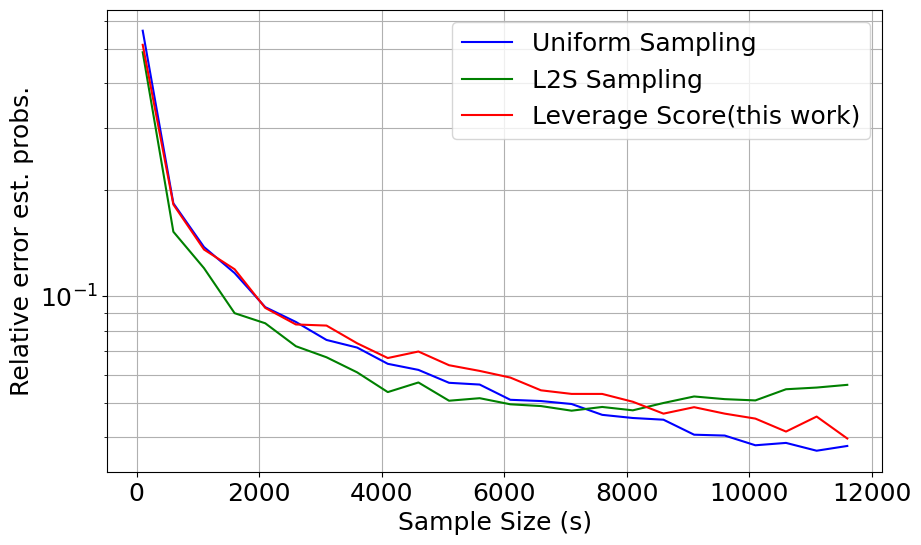

In [37]:
# Smooth the curves using a rolling average with window size
window_size =1

smoothed_lev_prob = np.convolve(mean_rel_est_probs_lev_array, np.ones(window_size)/window_size, mode='valid')
smoothed_l2s_prob = np.convolve(mean_rel_est_probs_l2s_array, np.ones(window_size)/window_size, mode='valid')
smoothed_unif_prob = np.convolve(mean_rel_est_probs_unif_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))

plt.plot(s_values[window_size-1:], smoothed_unif_prob, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_l2s_prob, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_lev_prob, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Relative error est. probs.",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\prob_default.png', dpi=300)
plt.show()

# **Plot misclassification rates for the various sampling methods**

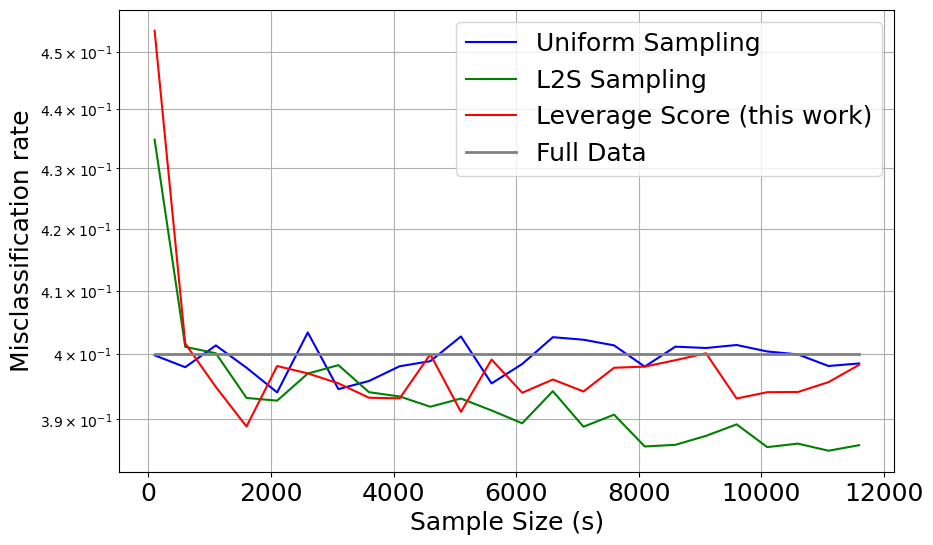

In [38]:
# Smooth the curves using a rolling average with window size
window_size =1

smoothed_lev_mis = np.convolve(mean_lev_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')
smoothed_l2s_mis = np.convolve(mean_l2s_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')
smoothed_unif_mis = np.convolve(mean_unif_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))

optimal_misclassification_rate = np.full(len(s_values[window_size-1:]), opt_misclassification_rate)



plt.plot(s_values[window_size-1:], smoothed_unif_mis, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_l2s_mis, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_lev_mis, label="Leverage Score (this work)", color='r')

plt.plot(s_values[window_size-1:], optimal_misclassification_rate, label="Full Data", color='gray', linestyle='-',linewidth=2)


plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Misclassification rate",fontsize=18)
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(True, which='both')
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\mis_default.png', dpi=300)
plt.show()

# **Plot relative error subsampled NLL for the various sampling methods**

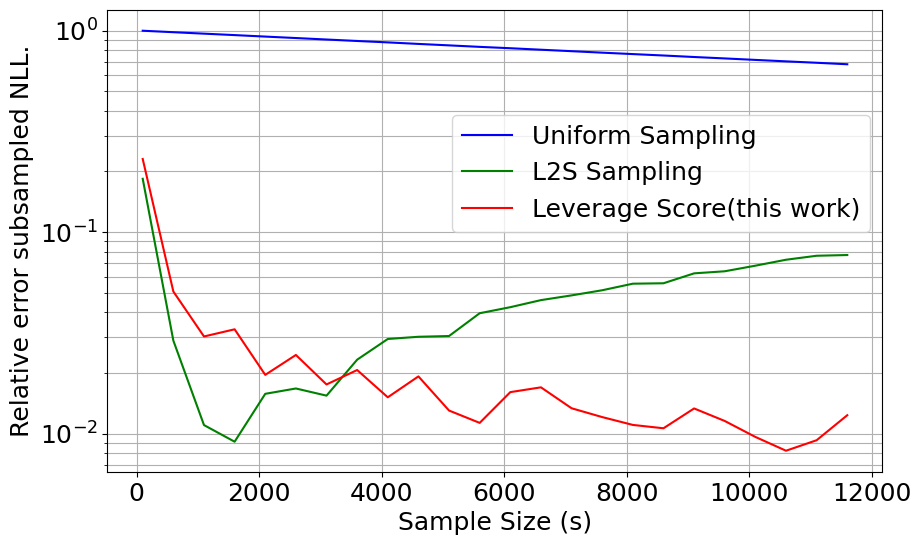

In [39]:
# Smooth the curves using a rolling average with window size 5
window_size =1

smoothed_lev_NLL = np.convolve(mean_rel_lev_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_l2s_NLL = np.convolve(mean_rel_l2s_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_unif_NLL = np.convolve(mean_rel_unif_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')

# Plot the mean values for misclassification rates with smoothed curves
plt.figure(figsize=(10, 6))


plt.plot(s_values[window_size-1:], smoothed_unif_NLL, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_l2s_NLL, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_lev_NLL, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Relative error subsampled NLL.",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 0.8))
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\subsampled_NLL_default.png', dpi=300)
plt.show()

# **Plot relative error true NLL for the various sampling methods**

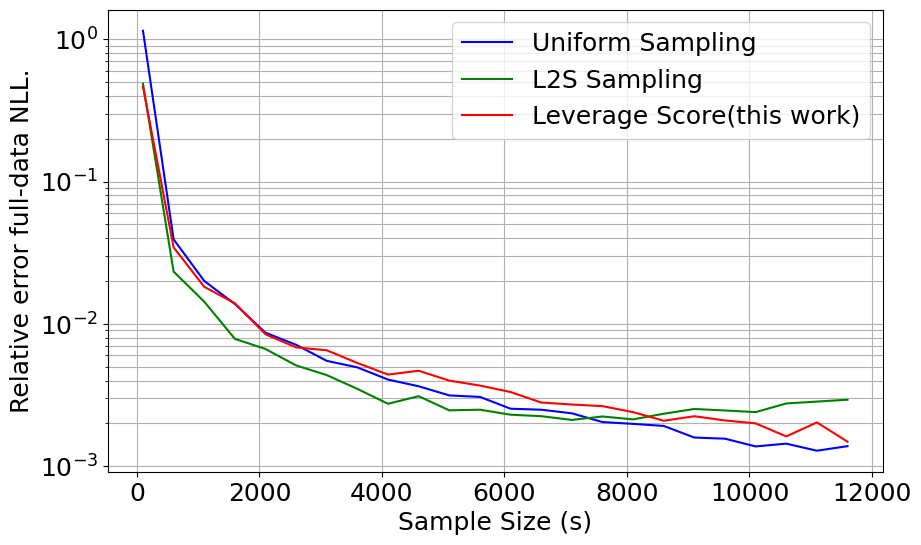

In [40]:
# Smooth the curves using a rolling average with window size 5
window_size =1

smoothed_lev_true_NLL = np.convolve(mean_rel_lev_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_l2s_true_NLL = np.convolve(mean_rel_l2s_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_unif_true_NLL = np.convolve(mean_rel_unif_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')

# Plot the mean values for misclassification rates with smoothed curves
plt.figure(figsize=(10, 6))


plt.plot(s_values[window_size-1:], smoothed_unif_true_NLL, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_l2s_true_NLL, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_lev_true_NLL, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Relative error full-data NLL.",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\fulldata_NLL_default.png', dpi=300)
plt.show()

# **Plot the standard deviations**

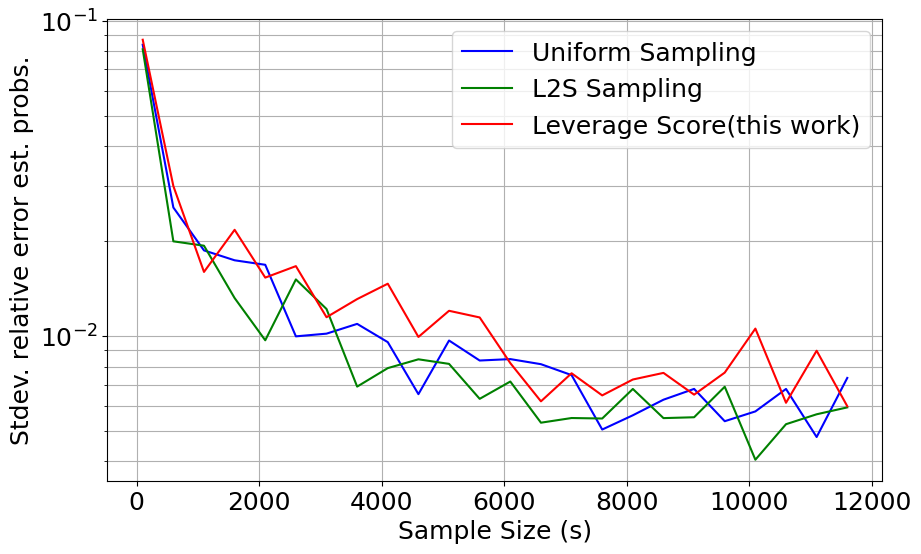

In [41]:
# Smooth the curves using a rolling average with window size
window_size =1

smoothed_std_lev_prob = np.convolve(std_rel_est_probs_lev_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_l2s_prob = np.convolve(std_rel_est_probs_l2s_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_unif_prob = np.convolve(std_rel_est_probs_unif_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))

plt.plot(s_values[window_size-1:], smoothed_std_unif_prob, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_std_l2s_prob, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_std_lev_prob, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Stdev. relative error est. probs.",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\stdev_prob_default.png', dpi=300)
plt.show()

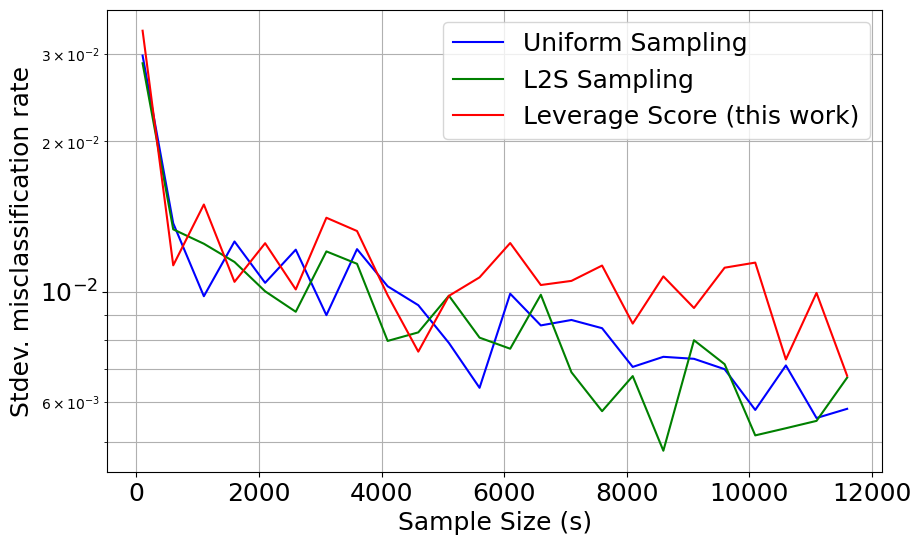

In [42]:
# Smooth the curves using a rolling average with window size
window_size =1

smoothed_std_lev_mis = np.convolve(std_lev_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_l2s_mis = np.convolve(std_l2s_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_unif_mis = np.convolve(std_unif_misclassification_rate_array, np.ones(window_size)/window_size, mode='valid')

plt.figure(figsize=(10, 6))



plt.plot(s_values[window_size-1:], smoothed_std_unif_mis, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_std_l2s_mis, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_std_lev_mis, label="Leverage Score (this work)", color='r')


plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Stdev. misclassification rate",fontsize=18)
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.grid(True, which='both')
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\stdev_mis_default.png', dpi=300)
plt.show()

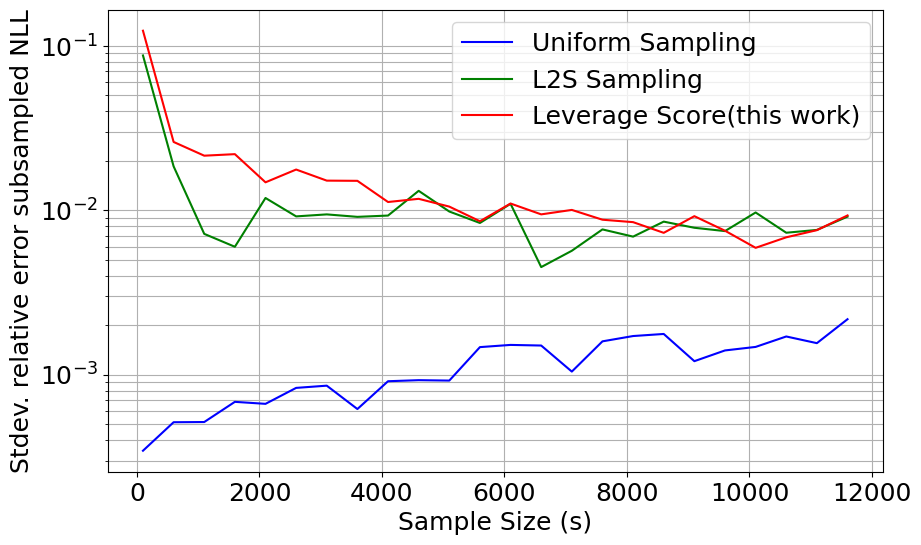

In [43]:
# Smooth the curves using a rolling average with window size 5
window_size =1

smoothed_std_lev_NLL = np.convolve(std_rel_lev_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_l2s_NLL = np.convolve(std_rel_l2s_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_unif_NLL = np.convolve(std_rel_unif_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')

# Plot the mean values for misclassification rates with smoothed curves
plt.figure(figsize=(10, 6))


plt.plot(s_values[window_size-1:], smoothed_std_unif_NLL, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_std_l2s_NLL, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_std_lev_NLL, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Stdev. relative error subsampled NLL",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 1))
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\stdev_subsampled_NLL_default.png', dpi=300)
plt.show()

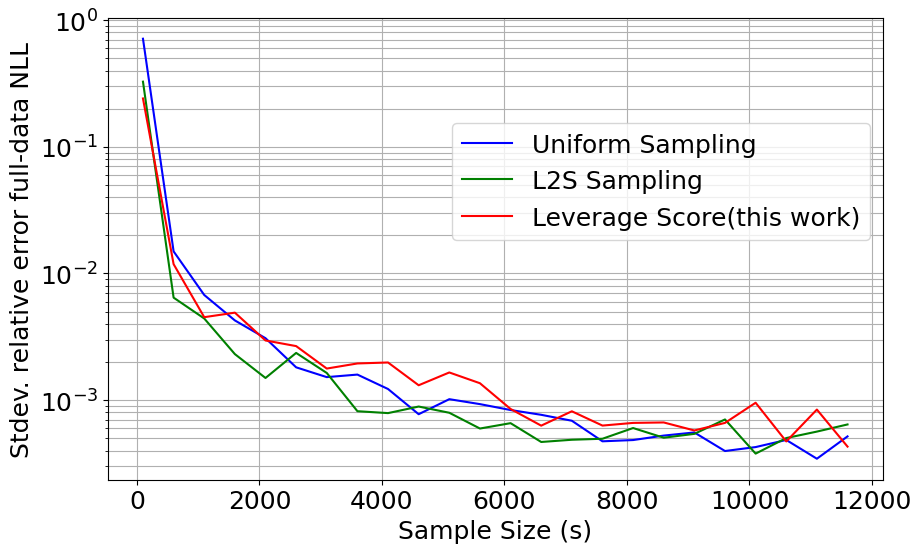

In [44]:
# Smooth the curves using a rolling average with window size 5
window_size =1

smoothed_std_lev_true_NLL = np.convolve(std_rel_lev_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_l2s_true_NLL = np.convolve(std_rel_l2s_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')
smoothed_std_unif_true_NLL = np.convolve(std_rel_unif_true_neg_log_likelihood_array, np.ones(window_size)/window_size, mode='valid')

# Plot the mean values for misclassification rates with smoothed curves
plt.figure(figsize=(10, 6))


plt.plot(s_values[window_size-1:], smoothed_std_unif_true_NLL, label="Uniform Sampling", color='b')
plt.plot(s_values[window_size-1:], smoothed_std_l2s_true_NLL, label="L2S Sampling", color='g')
plt.plot(s_values[window_size-1:], smoothed_std_lev_true_NLL, label="Leverage Score(this work)", color='r')

plt.xlabel("Sample Size (s)", fontsize=18)
plt.ylabel("Stdev. relative error full-data NLL",fontsize=18)
plt.legend(fontsize=18)
plt.grid(True, which='both')
plt.legend(fontsize=18, loc='upper right', bbox_to_anchor=(1, 0.8))
plt.yscale('log')  # Set y-axis to log scale
# plt.xscale('log')

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.savefig('plots\\stdev_fulldata_NLL_default.png', dpi=300)
plt.show()